# Assignment 1: Wrangling and EDA
### Foundations of Machine Learning 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

DATA_DIR = "./data"

def read_csv_robust(path, **kwargs):
    for enc in ["utf-8", "cp1252", "latin1"]:
        try:
            return pd.read_csv(path, encoding=enc, encoding_errors="replace", **kwargs)
        except UnicodeDecodeError:
            pass
    return pd.read_csv(path, encoding="latin1", encoding_errors="replace", **kwargs)

**Q1.** This question provides some practice cleaning variables which have common problems.
1. Numeric variable: For `airbnb_NYC.csv`, clean the `Price` variable as well as you can, and explain the choices you make. How many missing values do you end up with? (Hint: What happens to the formatting when a price goes over 999 dollars, say from 675 to 1,112?)
2. Categorical variable: For the Minnesota police use of for data, `mn_police_use_of_force.csv`, clean the `subject_injury` variable, handling the NA's; this gives a value `Yes` when a person was injured by police, and `No` when no injury occurred. What proportion of the values are missing? Cross-tabulate your cleaned `subject_injury` variable with the `force_type` variable. Are there any patterns regarding when the data are missing? For the remaining missing values, replace the `np.nan/None` values with the label `Missing`.
3. Dummy variable: For `metabric.csv`, convert the `Overall Survival Status` variable into a dummy/binary variable, taking the value 0 if the patient is deceased and 1 if they are living.
4. Missing values: For `airbnb_NYC.csv`, determine how many missing values of `Review Scores Rating` there are. Create a new variable, in which you impute the median score for non-missing observations to the missing ones. Why might this bias or otherwise negatively impact your results?

In [2]:
airbnb = read_csv_robust(f"{DATA_DIR}/airbnb_NYC.csv")

price_raw = airbnb["Price"].astype("string")
price_clean = (
    price_raw
    .str.replace("$", "", regex=False)
    .str.replace(",", "", regex=False)
    .str.strip()
)

airbnb["Price_clean"] = pd.to_numeric(price_clean, errors="coerce")

airbnb[["Price", "Price_clean"]].head(), airbnb["Price_clean"].isna().sum()

(  Price  Price_clean
 0   145          145
 1    37           37
 2    28           28
 3   199          199
 4   549          549,
 np.int64(0))

### Q1.1 Notes (Price)
I removed dollar signs and commas (so values like 1,112 parse correctly), stripped whitespace, and converted to numeric with errors='coerce' so any unparseable entries become missing (NaN). The output above shows the resulting number of missing values.

In [3]:
mn = read_csv_robust(f"{DATA_DIR}/mn_police_use_of_force.csv")

mn["subject_injury"].head(), mn["subject_injury"].isna().mean()

(0    NaN
 1    NaN
 2    NaN
 3    NaN
 4    NaN
 Name: subject_injury, dtype: object,
 np.float64(0.7619342359767892))

In [4]:
mn["subject_injury"].astype("string").str.strip().str.upper().value_counts(dropna=False).head(20)

subject_injury
<NA>    9848
YES     1631
NO      1446
Name: count, dtype: Int64

In [5]:
inj = mn["subject_injury"].astype("string").str.strip().str.upper()

inj_clean = pd.Series(pd.NA, index=mn.index, dtype="string")
inj_clean[inj.isna() | inj.eq("<NA>") | inj.eq("NAN") | inj.eq("NONE") | inj.eq("")] = pd.NA
inj_clean[inj.isin(["YES", "Y", "INJURED", "INJURY"]) ] = "Yes"
inj_clean[inj.isin(["NO", "N", "NOT INJURED", "NONE OBSERVED"]) ] = "No"

mn["subject_injury_clean"] = inj_clean

mn["subject_injury_clean"].isna().mean(), mn["subject_injury_clean"].value_counts(dropna=False)

(np.float64(0.7619342359767892),
 subject_injury_clean
 <NA>    9848
 Yes     1631
 No      1446
 Name: count, dtype: Int64)

In [6]:
mn["subject_injury_clean_filled"] = mn["subject_injury_clean"].fillna("Missing")

pd.crosstab(mn["subject_injury_clean_filled"], mn["force_type"], dropna=False)

force_type,Baton,Bodily Force,Chemical Irritant,Firearm,Gun Point Display,Improvised Weapon,Less Lethal,Less Lethal Projectile,Maximal Restraint Technique,Police K9 Bite,Taser
subject_injury_clean_filled,,,,,,,,,,,
Missing,2,7051,1421,0,27,74,87,0,170,31,985
No,0,1093,131,2,33,34,0,1,0,2,150
Yes,2,1286,41,0,44,40,0,2,0,44,172


In [7]:
metabric = read_csv_robust(f"{DATA_DIR}/metabric.csv")

metabric["Overall Survival Status"].astype("string").str.strip().value_counts(dropna=False).head(10)

Overall Survival Status
1:DECEASED    768
0:LIVING      575
Name: count, dtype: Int64

In [8]:
status = metabric["Overall Survival Status"].astype("string").str.strip().str.lower()

metabric["overall_survival_dummy"] = np.select(
    [status.str.contains("living", na=False), status.str.contains("deceased", na=False)],
    [1, 0],
    default=np.nan,
)

metabric[["Overall Survival Status", "overall_survival_dummy"]].head(), metabric["overall_survival_dummy"].value_counts(dropna=False)

(  Overall Survival Status  overall_survival_dummy
 0                0:LIVING                     1.0
 1              1:DECEASED                     0.0
 2                0:LIVING                     1.0
 3              1:DECEASED                     0.0
 4              1:DECEASED                     0.0,
 overall_survival_dummy
 0.0    768
 1.0    575
 Name: count, dtype: int64)

In [9]:
airbnb["Review Scores Rating"].isna().sum(), airbnb["Review Scores Rating"].median(skipna=True)

(np.int64(8323), np.float64(94.0))

In [10]:
med_review = airbnb["Review Scores Rating"].median(skipna=True)

airbnb["Review_Scores_Rating_imputed"] = airbnb["Review Scores Rating"].fillna(med_review)

airbnb[["Review Scores Rating", "Review_Scores_Rating_imputed"]].head()

,Review Scores Rating,Review_Scores_Rating_imputed
0,NaN,94.0
1,NaN,94.0
2,NaN,94.0
3,NaN,94.0
4,96.0,96.0


### Q1.4 Note (median imputation)
Imputing the median shrinks variation and can bias relationships (for example, it can weaken correlations between review score and price/occupancy) because the imputed values are not real observations and are more similar to each other than the true missing values would have been.

**Q2.** Go to https://sharkattackfile.net/ and download their dataset on shark attacks.

1. Open the shark attack file using Pandas. It is probably not a csv file, so `read_csv` won't work. What does work?
2. Drop any columns that do not contain data.
3. What is an observation? Carefully justify your answer, and explain how it affects your choices in cleaning and analyzing the data.
4. Clean the year variable. Describe the range of values you see. Filter the rows to focus on attacks since 1940. Are attacks increasing, decreasing, or remaining constant over time?
5. Clean the Age variable and make a histogram of the ages of the victims.
6. Clean the `Type` variable so it only takes three values: Provoked and Unprovoked and Unknown. What proportion of attacks are unprovoked?
7. Clean the `Fatal Y/N` variable so it only takes three values: Y, N, and Unknown.
8. Is the attack more or less likely to be fatal when the attack is provoked or unprovoked? Thoughts?

In [11]:
sharks = read_csv_robust(f"{DATA_DIR}/sharks.csv", low_memory=False)

sharks = sharks.dropna(axis=1, how="all")

sharks.shape, sharks.columns[:10]

((6462, 24),
 Index(['index', 'Case Number', 'Date', 'Year', 'Type', 'Country', 'Area',
        'Location', 'Activity', 'Name'],
       dtype='object'))

### Q2.1 Notes (reading the file)
On the sharkattackfile.net site, the dataset is often provided as an Excel file (.xlsx), so pd.read_excel(...) typically works.

Here, we already have a cleaned export in ./data/sharks.csv, so pd.read_csv(...) works.

### Q2.2–Q2.8 Shark attacks (cleaning + EDA)

### Q2 Answers
1. The downloaded file from sharkattackfile.net is often an Excel file (`.xlsx`), so `pd.read_excel(...)` works. In this repo we already have `./data/sharks.csv`, so `pd.read_csv(...)` works.
2. Dropping columns with no data: `df.dropna(axis=1, how='all')`.
3. **Observation:** one row is one recorded shark-attack incident (one event). So we keep one row per incident while cleaning (we standardize values in columns, not reshape into multiple rows unless changing the unit of analysis).

In [12]:
sharks.head()

,index,Case Number,Date,Year,Type,Country,Area,Location,Activity,Name,...,Time,Species,Investigator or Source,pdf,href formula,href,Case Number.1,Case Number.2,original order,Unnamed: 23
0,0,2020.02.05,05-Feb-2020,2020.0,Unprovoked,USA,Maui,NaN,Stand-Up Paddle boarding,NaN,...,09h40,Tiger shark,"K. McMurray, TrackingSharks.com",NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2020.01.30.R,Reported 30-Jan-2020,2020.0,Provoked,BAHAMAS,Exumas,NaN,Floating,Ana Bruna Avila,...,NaN,NaN,"K. McMurray, TrackingSharks.com",NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2020.01.17,17-Jan-2020,2020.0,Unprovoked,AUSTRALIA,New South Wales,Windang Beach,Surfing,Will Schroeter,...,08h00,"""A small shark""","B. Myatt & M. Michaelson, GSAF; K. McMurray, T...",2020.01.17-Schroeter.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2020.01.17,2020.01.17,6502.0,NaN
3,3,2020.01.16,16-Jan-2020,2020.0,Unprovoked,NEW ZEALAND,Southland,Oreti Beach,Surfing,Jordan King,...,20h30,Broadnose seven gill shark?,"K. McMurray, TrackingSharks.com",2020.01.16-King.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2020.01.16,2020.01.16,6501.0,NaN
4,4,2020.01.13,13-Jan-2020,2020.0,Unprovoked,USA,North Carolina,"Rodanthe, Dare County",Surfing,Samuel Horne,...,14h33,NaN,"C. Creswell, GSAF",2020.01.13-Horne.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2020.01.13,2020.01.13,6500.0,NaN


In [13]:
year_col = next((c for c in sharks.columns if c.strip().lower() == "year"), None)
age_col = next((c for c in sharks.columns if c.strip().lower() == "age"), None)
type_col = next((c for c in sharks.columns if c.strip().lower() == "type"), None)
fatal_col = next((c for c in sharks.columns if c.strip().lower() in ["fatal y/n", "fatal", "fatal (y/n)"]), None)

year_raw = sharks[year_col].astype("string")
year_num = pd.to_numeric(year_raw.str.extract(r"(\d{4})")[0], errors="coerce")

# Drop clearly impossible years (data-entry / parsing issues)
current_year = pd.Timestamp.now().year
sharks["Year_clean"] = year_num.where((year_num >= 1500) & (year_num <= current_year))

sharks["Year_clean"].describe()

count         6330.0
mean     1968.374566
std        48.574824
min           1543.0
25%           1946.0
50%           1981.0
75%           2006.0
max           2020.0
Name: Year_clean, dtype: Float64

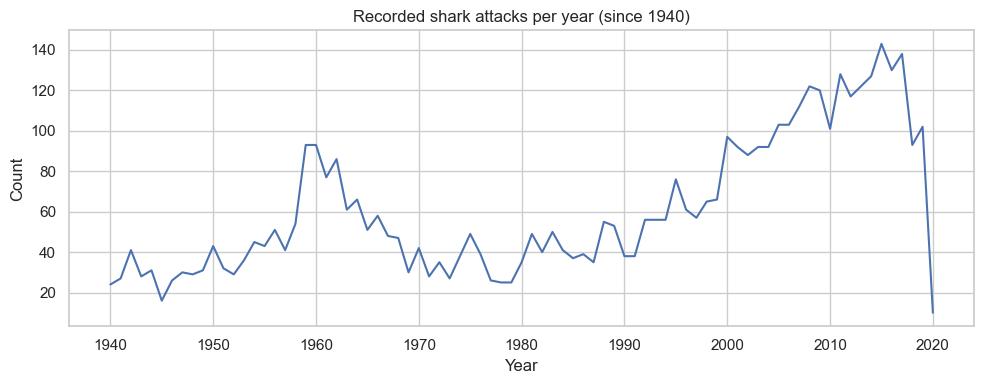

(np.int64(1940), np.int64(2020))

In [14]:
sharks_1940 = sharks.loc[(sharks["Year_clean"] >= 1940) & (sharks["Year_clean"].notna())].copy()
attacks_by_year = sharks_1940.groupby("Year_clean").size().sort_index()

plt.figure(figsize=(10,4))
attacks_by_year.plot()
plt.title("Recorded shark attacks per year (since 1940)")
plt.xlabel("Year")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

attacks_by_year.index.min(), attacks_by_year.index.max()

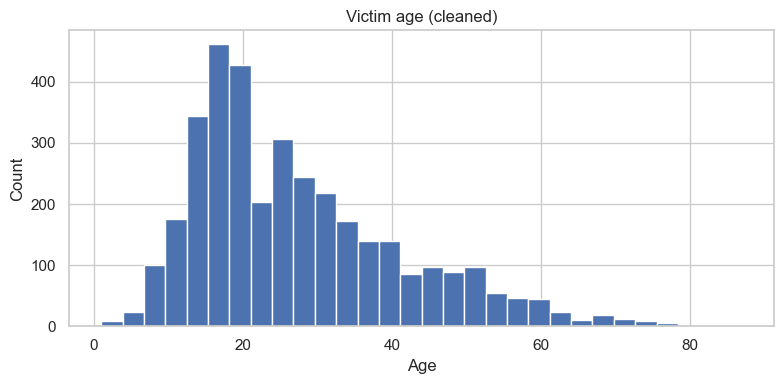

count       3564.0
mean     27.458474
std      14.069441
min            1.0
25%           17.0
50%           24.0
75%           35.0
max           87.0
Name: Age_clean, dtype: Float64

In [15]:
age_raw = sharks[age_col].astype("string").str.strip().str.lower()
age_num = pd.to_numeric(age_raw.str.extract(r"(\d+)")[0], errors="coerce")
sharks["Age_clean"] = age_num.where((age_num >= 0) & (age_num <= 100))

plt.figure(figsize=(8,4))
sharks["Age_clean"].dropna().plot.hist(bins=30)
plt.title("Victim age (cleaned)")
plt.xlabel("Age")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

sharks["Age_clean"].describe()

In [16]:
t = sharks[type_col].astype("string").str.strip().str.lower()

# Robust 3-level cleaning for Type:
# - extract keyword "unprovoked" or "provoked" if present
# - treat everything else as Unknown
key = t.str.extract(r"(unprovoked|provoked)", expand=False)

sharks["Type_clean"] = "Unknown"
sharks.loc[key.eq("unprovoked"), "Type_clean"] = "Unprovoked"
sharks.loc[key.eq("provoked"), "Type_clean"] = "Provoked"

# sanity checks
(
    t.value_counts(dropna=False).head(10),
    sharks["Type_clean"].value_counts(dropna=False),
    sharks["Type_clean"].eq("Unprovoked").mean(),
)

(Type
 unprovoked      4716
 provoked         593
 invalid          552
 sea disaster     239
 watercraft       142
 boat             109
 boating           92
 questionable      10
 <NA>               5
 unconfirmed        1
 Name: count, dtype: Int64,
 Type_clean
 Unprovoked    4716
 Unknown       1153
 Provoked       593
 Name: count, dtype: int64,
 np.float64(0.7298050139275766))

In [17]:
f = sharks[fatal_col].astype("string").str.strip().str.upper()

fatal_clean = pd.Series("Unknown", index=sharks.index, dtype="string")
fatal_clean[f.eq("Y")] = "Y"
fatal_clean[f.eq("N")] = "N"

sharks["Fatal_clean"] = fatal_clean

sharks["Fatal_clean"].value_counts(dropna=False)

Fatal_clean
N          4439
Y          1401
Unknown     622
Name: count, dtype: Int64

In [18]:
pd.crosstab(sharks["Type_clean"], sharks["Fatal_clean"], normalize="index")

Fatal_clean,N,Unknown,Y
Type_clean,,,
Provoked,0.954469,0.013491,0.032040
Unknown,0.359063,0.475282,0.165655
Unprovoked,0.733461,0.013995,0.252545


### Q2.8 Note
The table above compares fatality rates within each `Type_clean` category. This is **descriptive**, not causal: reporting differences and context (where/when/why an interaction occurred) can affect both provocation classification and whether the incident is recorded as fatal.

### Q3 Answers
1. The paper is about a simple, consistent way to organize data (“tidy data”) so it’s easier to clean, analyze, and model. It focuses on how the structure of a dataset affects the ease of doing analysis and using tools.
2. The tidy data standard is intended to make datasets consistent across projects so common operations (summaries, plotting, modeling) are straightforward and less error-prone.
3. “Like families, tidy datasets are all alike but every messy dataset is messy in its own way” means there’s basically one standard way for data to be tidy, but there are many different ways for data to be messy (so cleaning is often dataset specific). The second quote means that although we can usually identify rows/columns/values in a given dataset, it’s harder to define “observation” and “variable” in a universal way because it depends on the analytic goal and what process generated the data.
4. Values are the actual entries in cells. Variables are the measured attributes (concepts) that vary across observations and should form columns. Observations are the units being measured and should form rows.
5. Tidy data: each variable forms a column, each observation forms a row, and each type of observational unit forms a table.
6. The 5 common messy data problems are (paraphrasing Wickham):
   - Column headers are values, not variable names.
   - Multiple variables are stored in one column.
   - Variables are stored in both rows and columns.
   - Multiple types of observational units are stored in the same table.
   - A single observational unit is stored in multiple tables.
   Table 4 is messy because the structure mixes variables/values (so the “names” are encoding data). Melting is reshaping wide data into a longer format so that measured values live in one column and former column labels become values of a variable.
7. Table 11 is messy because values that should be in variables/columns are embedded in multiple columns (so the data isn’t in a consistent variable/observation layout). Table 12 is tidy after restructuring (“molten”) because the variable/value structure is normalized: the measurement is in one column and identifiers/conditions are in separate columns.

**Q3.** Open the "tidy_data.pdf" document available in `https://github.com/ds4e/wrangling`, which is a paper called *Tidy Data* by Hadley Wickham.

  1. Read the abstract. What is this paper about?
  2. Read the introduction. What is the "tidy data standard" intended to accomplish?
  3. Read the intro to section 2. What does this sentence mean: "Like families, tidy datasets are all alike but every messy dataset is messy in its own way." What does this sentence mean: "For a given dataset, it’s usually easy to figure out what are observations and what are variables, but it is surprisingly difficult to precisely define variables and observations in general."
  4. Read Section 2.2. How does Wickham define values, variables, and observations?
  5. How is "Tidy Data" defined in section 2.3?
  6. Read the intro to Section 3 and Section 3.1. What are the 5 most common problems with messy datasets? Why are the data in Table 4 messy? What is "melting" a dataset?
  7. Why, specifically, is table 11 messy but table 12 tidy and "molten"?

**Q4.** This question looks at financial transfers from international actors to American universities. In particular, from which countries and giftors are the gifts coming from, and to which institutions are they going? 

For this question, `.groupby([vars]).count()` and `.groupby([vars]).sum()` will be especially useful to tally the number of occurrences and sum the values of those occurrences.

1. Load the `ForeignGifts_edu.csv` dataset.
2. For `Foreign Gift Amount`, create a histogram and describe the variable. Describe your findings.
3. For `Gift Type`, create a histogram or value counts table. What proportion of the gifts are contracts, real estate, and monetary gifts?
4. What are the top 15 countries in terms of the number of gifts? What are the top 15 countries in terms of the amount given?
5. What are the top 15 institutions in terms of the total amount of money they receive? Make a histogram of the total amount received by all institutions. 
6. Which giftors provide the most money, in total? 

### Q4 Answers (Foreign gifts)

In [19]:
gifts = read_csv_robust(f"{DATA_DIR}/ForeignGifts_edu.csv", low_memory=False)

gifts.shape, gifts.head()

((28221, 10),
    ID   OPEID               Institution Name          City State  \
 0   1  102000  Jacksonville State University  Jacksonville    AL   
 1   2  104700                Troy University          Troy    AL   
 2   3  105100          University of Alabama    Tuscaloosa    AL   
 3   4  105100          University of Alabama    Tuscaloosa    AL   
 4   5  105100          University of Alabama    Tuscaloosa    AL   
 
    Foreign Gift Received Date  Foreign Gift Amount      Gift Type  \
 0                       43738               250000  Monetary Gift   
 1                       43592               463657       Contract   
 2                       43466              3649107       Contract   
 3                       43472                 1000       Contract   
 4                       43479                49476       Contract   
 
   Country of Giftor                          Giftor Name  
 0             CHINA                                  NaN  
 1             CHINA     Con

In [20]:
gifts.columns

Index(['ID', 'OPEID', 'Institution Name', 'City', 'State',
       'Foreign Gift Received Date', 'Foreign Gift Amount', 'Gift Type',
       'Country of Giftor', 'Giftor Name'],
      dtype='object')

In [21]:
def find_col(df, options):
    cols = {c.strip().lower(): c for c in df.columns}
    for opt in options:
        k = opt.strip().lower()
        if k in cols:
            return cols[k]
    # try contains as fallback
    for opt in options:
        k = opt.strip().lower()
        for lc, orig in cols.items():
            if k in lc:
                return orig
    return None

amt_col = find_col(gifts, ["Foreign Gift Amount", "ForeignGiftAmount", "Gift Amount", "Amount"])
type_col = find_col(gifts, ["Gift Type", "GiftType", "Type"])
country_col = find_col(gifts, ["Country"])
institution_col = find_col(gifts, ["Institution", "Institution Name", "InstitutionName", "School"])
giftor_col = find_col(gifts, ["Giftor", "Giftor Name", "GiftorName", "Donor", "Source"])

amt_col, type_col, country_col, institution_col, giftor_col

('Foreign Gift Amount',
 'Gift Type',
 'Country of Giftor',
 'Institution Name',
 'Giftor Name')

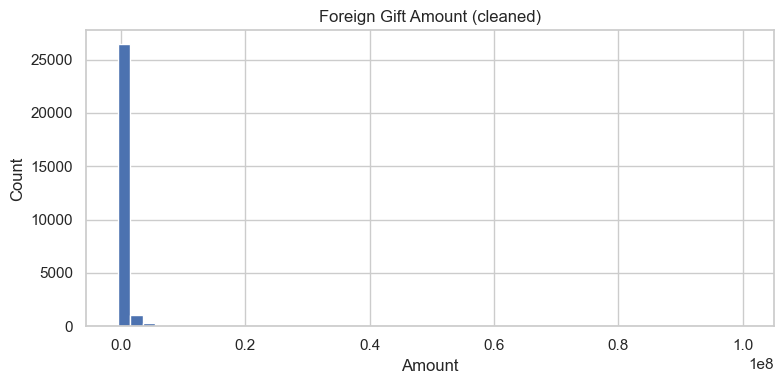

Gift Type
Contract         17274
Monetary Gift    10936
Real Estate         11
Name: count, dtype: Int64

Gift Type
Contract         0.612097
Monetary Gift    0.387513
Real Estate       0.00039
Name: count, dtype: Float64

Country of Giftor
ENGLAND            3655
CHINA              2461
CANADA             2344
JAPAN              1896
SWITZERLAND        1676
SAUDI ARABIA       1610
FRANCE             1437
GERMANY            1394
HONG KONG          1080
SOUTH KOREA         811
QATAR               693
THE NETHERLANDS     512
KOREA               452
INDIA               434
TAIWAN              381
dtype: int64

Country of Giftor
QATAR                   2706240869
ENGLAND                 1464906771
CHINA                   1237952112
SAUDI ARABIA            1065205930
BERMUDA                  899593972
CANADA                   898160656
HONG KONG                887402529
JAPAN                    655954776
SWITZERLAND              619899445
INDIA                    539556490
GERMANY                  442475605
UNITED ARAB EMIRATES     431396357
FRANCE                   405839396
SINGAPORE                401157692
AUSTRALIA                248409202
Name: foreign_gift_amount_clean, dtype: Int64

Institution Name
Carnegie Mellon University                       1477922504
Cornell University                               1289937761
Harvard University                                954803610
Massachusetts Institute of Technology             859071692
Yale University                                   613441311
Texas A&M University                              521455050
Johns Hopkins University                          502409595
Northwestern University                           402316221
Georgetown University                             379950511
University of Chicago (The)                       364544338
University of Colorado Boulder                    360173159
Duke University                                   343699498
Brigham Young University                          323509863
Stanford University                               319561362
University of Texas MD Anderson Cancer Center     301527419
Name: foreign_gift_amount_clean, dtype: Int64

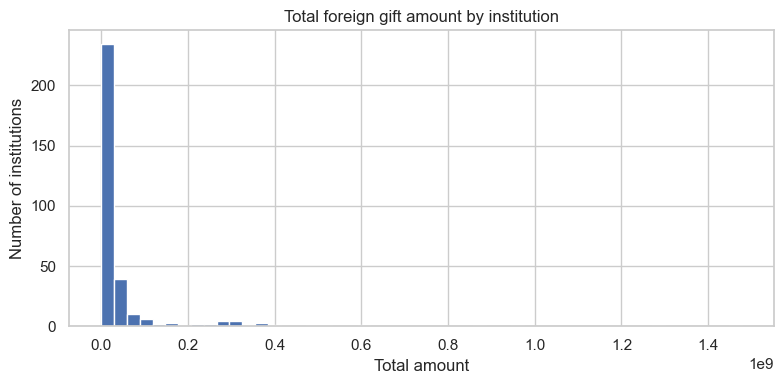

Giftor Name
Qatar Foundation                       1166503744
Qatar Foundation/Qatar National Res     796197000
Qatar Foundation for Education          373945215
Anonymous                               338793629
Saudi Arabian Cultural Mission          275221475
HCL                                     190000000
Church of Jesus Christ of LDS           185203715
Emirates Institute for Advanced Sc      170641244
QIC                                     148355497
Anonymous #9                             96334996
Qatar National Research Fund             79021705
Government of Saudi Arabia               75192434
Contracting Party                        69996984
CMKL University                          67700000
Royal Embassy of Saudi Arabia            67062486
Name: foreign_gift_amount_clean, dtype: Int64

In [22]:
# Clean amount to numeric
amt_raw = gifts[amt_col].astype("string").str.replace(",", "", regex=False).str.replace("$", "", regex=False).str.strip()
gifts["foreign_gift_amount_clean"] = pd.to_numeric(amt_raw, errors="coerce")

# Q4.2: histogram + describe
plt.figure(figsize=(8,4))
gifts["foreign_gift_amount_clean"].dropna().plot.hist(bins=50)
plt.title("Foreign Gift Amount (cleaned)")
plt.xlabel("Amount")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

gifts["foreign_gift_amount_clean"].describe()

# Q4.3: Gift Type proportions
if type_col is not None:
    gift_type_counts = gifts[type_col].astype("string").str.strip().value_counts(dropna=False)
    gift_type_props = gift_type_counts / gift_type_counts.sum()
    display(gift_type_counts)
    display(gift_type_props)

# Q4.4: Top 15 countries by count and amount
if country_col is not None:
    top_countries_count = gifts.groupby(country_col).size().sort_values(ascending=False).head(15)
    top_countries_amount = gifts.groupby(country_col)["foreign_gift_amount_clean"].sum().sort_values(ascending=False).head(15)
    display(top_countries_count)
    display(top_countries_amount)

# Q4.5: Top 15 institutions by total amount + histogram of totals
if institution_col is not None:
    inst_totals = gifts.groupby(institution_col)["foreign_gift_amount_clean"].sum().sort_values(ascending=False)
    display(inst_totals.head(15))

    plt.figure(figsize=(8,4))
    inst_totals.dropna().plot.hist(bins=50)
    plt.title("Total foreign gift amount by institution")
    plt.xlabel("Total amount")
    plt.ylabel("Number of institutions")
    plt.tight_layout()
    plt.show()

# Q4.6: Top giftors by total amount
if giftor_col is not None:
    giftor_totals = gifts.groupby(giftor_col)["foreign_gift_amount_clean"].sum().sort_values(ascending=False)
    display(giftor_totals.head(15))

**Q5.** This question provides some practice doing exploratory data analysis and visualization.

We'll use the `college_completion.csv` dataset from the US Department of Education. The "relevant" variables for this question are:
  - `level` - Level of institution (4-year, 2-year)
  - `aid_value` - The average amount of student aid going to undergraduate recipients
  - `control` - Public, Private not-for-profit, Private for-profit
  - `grad_100_value` - percentage of first-time, full-time, degree-seeking undergraduates who complete a degree or certificate program within 100 percent of expected time (bachelor's-seeking group at 4-year institutions)

1. Load the `college_completion.csv` data with Pandas.
2. How many observations and variables are in the data? Use `.head()` to examine the first few rows of data.
3. Cross tabulate `control` and `level`. Describe the patterns you see in words.
4. For `grad_100_value`, create a kernel density plot and describe table. Now condition on `control`, and produce a kernel density plot and describe tables for each type of institutional control. Which type of institution appear to have the most favorable graduation rates?
5. Make a scatterplot of `grad_100_value` by `aid_value`, and compute the covariance and correlation between the two variables. Describe what you see. Now make the same plot and statistics, but conditioning on `control`. Describe what you see. For which kinds of institutions does aid seem to vary positively with graduation rates?

### Q5 Answers (College completion)

In [23]:
college = read_csv_robust(f"{DATA_DIR}/college_completion.csv", low_memory=False)

college.shape, college.head()

((3798, 63),
    index  unitid                            chronname        city    state  \
 0      0  100654               Alabama A&M University      Normal  Alabama   
 1      1  100663  University of Alabama at Birmingham  Birmingham  Alabama   
 2      2  100690                   Amridge University  Montgomery  Alabama   
 3      3  100706  University of Alabama at Huntsville  Huntsville  Alabama   
 4      4  100724             Alabama State University  Montgomery  Alabama   
 
     level                 control  \
 0  4-year                  Public   
 1  4-year                  Public   
 2  4-year  Private not-for-profit   
 3  4-year                  Public   
 4  4-year                  Public   
 
                                                basic hbcu flagship  ...  \
 0  Masters Colleges and Universities--larger prog...    X      NaN  ...   
 1  Research Universities--very high research acti...  NaN      NaN  ...   
 2            Baccalaureate Colleges--Arts & Sciences

In [24]:
# Keep only the relevant columns (as described in the prompt)
cols = ["level", "aid_value", "control", "grad_100_value"]
missing = [c for c in cols if c not in college.columns]
missing

[]

In [25]:
college_q5 = college.copy()

# Coerce numeric columns (some datasets store these as strings)
for c in ["aid_value", "grad_100_value"]:
    if c in college_q5.columns:
        college_q5[c] = pd.to_numeric(college_q5[c], errors="coerce")

# Q5.3: crosstab control x level
pd.crosstab(college_q5["control"], college_q5["level"], dropna=False)

level,2-year,4-year
control,,
Private for-profit,465,527
Private not-for-profit,68,1180
Public,926,632


### Q5 Notes (extra detail)
- The college_completion.csv file often stores numeric columns as strings. The Q5 code uses pd.to_numeric(..., errors='coerce') so non-numeric entries become missing instead of crashing plots.
- When comparing graduation rates across control, prefer the grouped describe table (it gives mean, std, and quantiles) alongside the KDE plot.
- For the aid–graduation relationship, the overall covariance/correlation can hide very different patterns by control, so the by-control table is the most informative summary here.

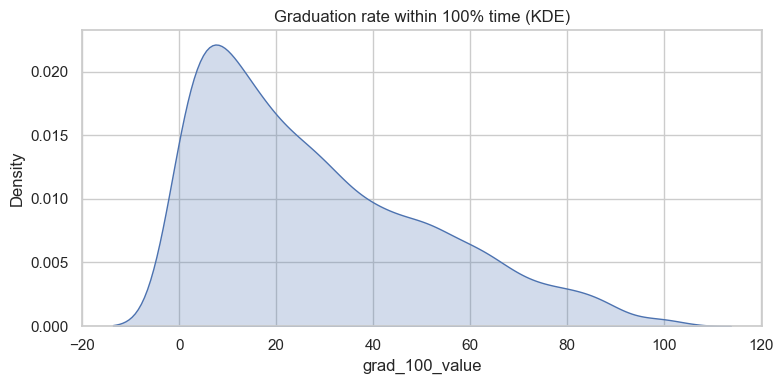

count    3467.000000
mean       28.364465
std        23.312730
min         0.000000
25%         9.000000
50%        22.500000
75%        43.650000
max       100.000000
Name: grad_100_value, dtype: float64

In [26]:
# Q5.4: KDE + describe for grad_100_value
plt.figure(figsize=(8,4))
sns.kdeplot(data=college_q5, x="grad_100_value", fill=True)
plt.title("Graduation rate within 100% time (KDE)")
plt.tight_layout()
plt.show()

college_q5["grad_100_value"].describe()

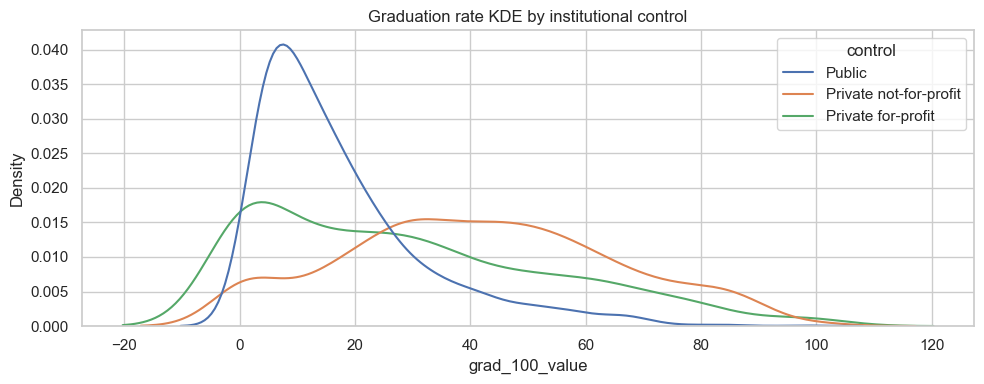

,count,mean,std,min,25%,50%,75%,max
control,,,,,,,,
Private for-profit,779.0,29.108858,25.601687,0.0,6.95,24.7,46.75,100.0
Private not-for-profit,1189.0,41.660976,23.551231,0.0,25.00,41.0,58.30,100.0
Public,1499.0,17.430887,14.729443,0.0,6.90,13.2,23.25,97.8


In [27]:
# Conditional KDEs by control + describe table by control
plt.figure(figsize=(10,4))
sns.kdeplot(data=college_q5, x="grad_100_value", hue="control", fill=False, common_norm=False)
plt.title("Graduation rate KDE by institutional control")
plt.tight_layout()
plt.show()

college_q5.groupby("control")["grad_100_value"].describe()

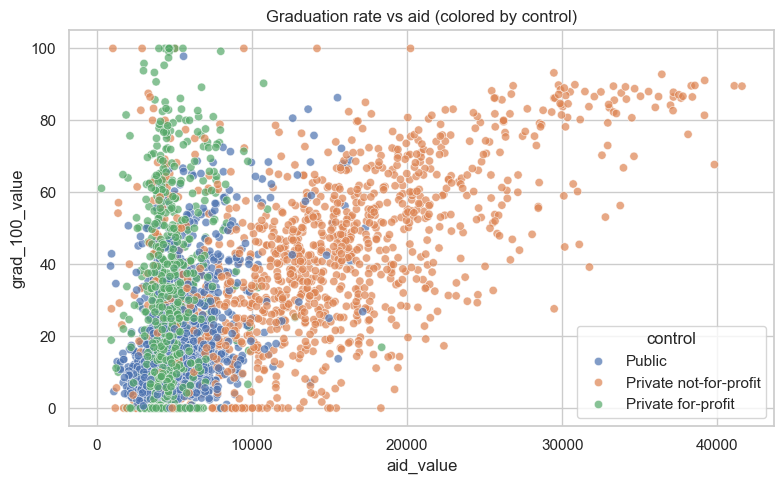

C:\Users\abela\AppData\Local\Temp\ipykernel_19440\676051067.py:12: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


,cov,corr,n,mean_grad
control,,,,
Private not-for-profit,109274.123337,0.601591,1189.0,41.660976
Private for-profit,6897.524957,0.188363,778.0,29.060283
Public,15355.146212,0.482481,1499.0,17.430887


In [28]:
# Conditioning on control: scatter + covariance/correlation by control
plt.figure(figsize=(8,5))
sns.scatterplot(data=college_q5, x="aid_value", y="grad_100_value", hue="control", alpha=0.7)
plt.title("Graduation rate vs aid (colored by control)")
plt.tight_layout()
plt.show()

by_control = (
    college_q5
    .dropna(subset=["aid_value", "grad_100_value", "control"])
    .groupby("control")
    .apply(lambda g: pd.Series({
        "cov": g[["aid_value", "grad_100_value"]].cov().iloc[0, 1],
        "corr": g[["aid_value", "grad_100_value"]].corr().iloc[0, 1],
        "n": len(g),
        "mean_grad": g["grad_100_value"].mean(),
    }))
    .sort_values("mean_grad", ascending=False)
)

by_control

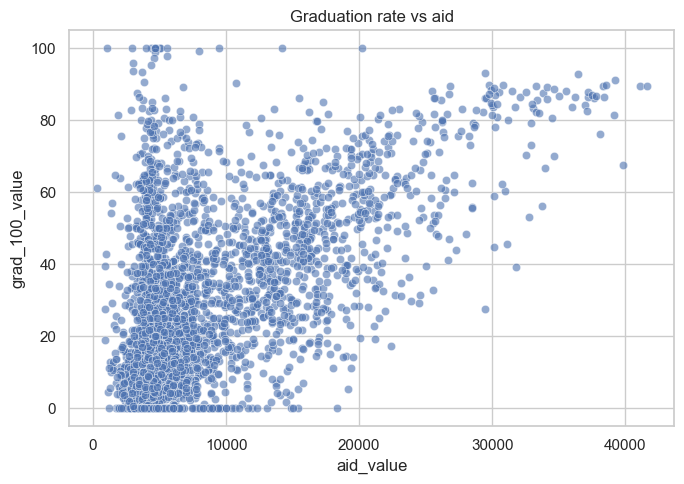

(np.float64(88610.48316902436), np.float64(0.5758792845936064))

In [29]:
# Q5.5: scatter + covariance/correlation overall
plt.figure(figsize=(7,5))
sns.scatterplot(data=college_q5, x="aid_value", y="grad_100_value", alpha=0.6)
plt.title("Graduation rate vs aid")
plt.tight_layout()
plt.show()

pair = college_q5[["aid_value", "grad_100_value"]].dropna()
overall_cov = pair.cov().iloc[0, 1]
overall_corr = pair.corr().iloc[0, 1]

overall_cov, overall_corr

### Q5 Notes (interpretation)
- For Q5.3, use the pd.crosstab(control, level) output to describe which combinations of control and level appear most common.
- For Q5.4, compare the KDEs/summary tables by control. The code computes mean_grad by control and prints which control has the highest average graduation rate as best_control.
- For Q5.5, the code prints the overall covariance/correlation and then prints covariance/correlation within each control group. The variable most_positive_corr_control identifies the control group with the most positive aid_value–grad_100_value correlation in this dataset.

In [30]:
# Simple data-driven summaries for the written parts
best_control = by_control["mean_grad"].idxmax() if len(by_control) else None
most_positive_corr_control = by_control["corr"].idxmax() if len(by_control) else None

best_control, most_positive_corr_control

('Private not-for-profit', 'Private not-for-profit')

**Q6.** In class, we talked about how to compute the sample mean of a variable $X$,
$$
m(X) = \dfrac{1}{N} \sum_{i=1}^N x_i
$$
and sample covariance of two variables $X$ and $Y$,
$$
\text{cov}(X,Y) = \dfrac{1}{N} \sum_{i=1}^N (x_i - m(X)) (y_i - m(Y)).
$$
Recall, the sample variance of $X$ is
$$
s^2 = \dfrac{1}{N} \sum_{i=1}^N (x_i - m(X))^2.
$$
It can be very helpful to understand some basic properties of these statistics. If you want to write your calculations on a piece of paper, take a photo, and upload that to your GitHub repo, that's probably easiest.

We're going to look at **linear transformations** of $X$, $Y = a + bX$. So we take each value of $X$, $x_i$, and transform it as $y_i = a + b x_i$. 

1. Show that $m(a + bX) = a+b \times m(X)$.
2. Show that $ \text{cov}(X,X) = s^2$.
3. Show that $\text{cov}(X,a+bY) = b \times \text{cov}(X,Y)$
4. Show that $\text{cov}(a+bX,a+bY) = b^2 \text{cov}(X,Y) $. Notice, this also means that $\text{cov}(bX, bX) = b^2 s^2$.
5. Suppose $b>0$ and let the median of $X$ be $\text{med}(X)$. Is it true that the median of $a+bX$ is equal to $a + b \times \text{med}(X)$? Is the IQR of $a + bX$ equal to $a + b \times \text{IQR}(X)$?
6. Show by example that the means of $X^2$ and $\sqrt{X}$ are generally not $(m(X))^2$ and $\sqrt{m(X)}$. So, the results we derived above really depend on the linearity of the transformation $Y = a + bX$, and transformations like $Y = X^2$ or $Y = \sqrt{X}$ will not behave in a similar way.

### Q6 Answers
1. Since $Y=a+bX$, we have
$$m(Y)=\frac{1}{N}\sum_{i=1}^N (a+bx_i)=a+b\frac{1}{N}\sum_{i=1}^N x_i=a+b\,m(X).$$

2. By definition,
$$\text{cov}(X,X)=\frac{1}{N}\sum_{i=1}^N (x_i-m(X))(x_i-m(X))=\frac{1}{N}\sum_{i=1}^N (x_i-m(X))^2=s^2.$$

3. $\text{cov}(X,a+bY)=\text{cov}(X,a)+\text{cov}(X,bY)$. The constant term drops out because $a-m(a)=0$, so $\text{cov}(X,a)=0$. Also scaling pulls out:
$$\text{cov}(X,bY)=b\,\text{cov}(X,Y).$$
So $\text{cov}(X,a+bY)=b\,\text{cov}(X,Y)$.

4. Using linearity in each argument and the same “constant drops out / scaling pulls out” logic:
$$\text{cov}(a+bX,a+bY)=b^2\,\text{cov}(X,Y).$$

5. For $b>0$, the transformation $x \mapsto a+bx$ is strictly increasing, so it preserves order. Therefore:
- median: $\text{med}(a+bX)=a+b\,\text{med}(X)$
- IQR: since both $Q_{0.75}$ and $Q_{0.25}$ shift/scale the same way, $\text{IQR}(a+bX)=b\,\text{IQR}(X)$.

6. Nonlinear transforms generally don’t commute with the mean: typically $m(g(X)) \neq g(m(X))$.

In [31]:
# Q6.6: examples where m(g(X)) != g(m(X))
X = np.array([0, 1, 4], dtype=float)

mX = X.mean()

mX2 = (X**2).mean()
X2_of_mX = mX**2

m_sqrtX = np.sqrt(X).mean()
sqrt_of_mX = np.sqrt(mX)

mX, mX2, X2_of_mX, m_sqrtX, sqrt_of_mX

(np.float64(1.6666666666666667),
 np.float64(5.666666666666667),
 np.float64(2.777777777777778),
 np.float64(1.0),
 np.float64(1.2909944487358056))

### Q6 Notes (extra detail)
- For **Q6.5 (median/IQR)** when \(b>0\), the transform \(x \mapsto a+bx\) is strictly increasing, so it preserves the ordering of the data. That means any *quantile* (including the median and the 25th/75th percentiles) transforms the same way: \(Q_p(a+bX)=a+bQ_p(X)\). Therefore the IQR transforms as:
  \[\text{IQR}(a+bX)=Q_{0.75}(a+bX)-Q_{0.25}(a+bX)=b\,Q_{0.75}(X)-b\,Q_{0.25}(X)=b\,\text{IQR}(X).\]
- For **Q6.6 (nonlinear examples)**, the code cell prints concrete numbers showing:
  - typically \(m(X^2)\neq (m(X))^2\)
  - typically \(m(\sqrt{X})\neq \sqrt{m(X)}\)
  This is why the earlier equalities work specifically for *linear* transformations.

**Q7.** This question provides some practice doing exploratory data analysis and visualization.

We'll use the `ames_prices.csv` dataset. The "relevant" variables for this question are:
  - `price` - Sale price value of the house
  - `Bldg.Type` - Building type of the house (single family home, end-of-unit townhome, duplex, interior townhome, two-family conversion)

1. Load the `college_completion.csv` data with Pandas.
2. Make a kernel density plot of price and compute a describe table. Now, make a kernel density plot of price conditional on building type, and use `.groupby()` to make a describe type for each type of building. Which building types are the most expensive, on average? Which have the highest variance in transaction prices?
3. Make an ECDF plot of price, and compute the sample minimum, .25 quantile, median, .75 quantile, and sample maximum (i.e. a 5-number summary).
4. Make a boxplot of price. Are there outliers? Make a boxplot of price conditional on building type. What patterns do you see?
5. Make a dummy variable indicating that an observation is an outlier.
6. Winsorize the price variable, and compute a new kernel density plot and describe table. How do the results change?

### Q7 Answers (Ames prices)

In [32]:
ames = read_csv_robust(f"{DATA_DIR}/ames_prices.csv")

ames.shape, ames[["price", "Bldg.Type"]].head()

((2930, 82),
     price Bldg.Type
 0  215000      1Fam
 1  105000      1Fam
 2  172000      1Fam
 3  244000      1Fam
 4  189900      1Fam)

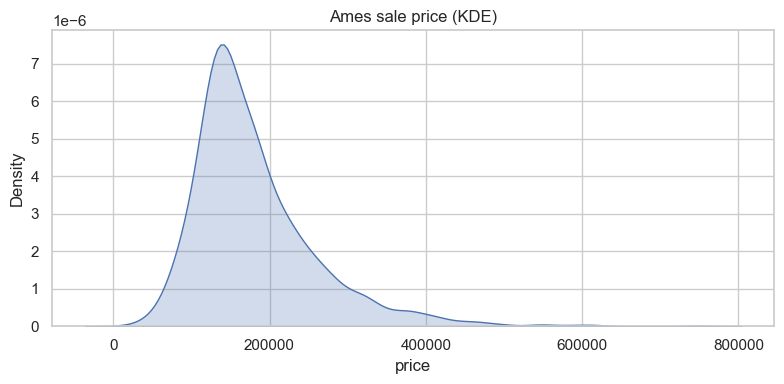

count      2930.000000
mean     180796.060068
std       79886.692357
min       12789.000000
25%      129500.000000
50%      160000.000000
75%      213500.000000
max      755000.000000
Name: price, dtype: float64

In [33]:
plt.figure(figsize=(8,4))

sns.kdeplot(data=ames, x="price", fill=True)
plt.title("Ames sale price (KDE)")
plt.tight_layout()
plt.show()

ames["price"].describe()

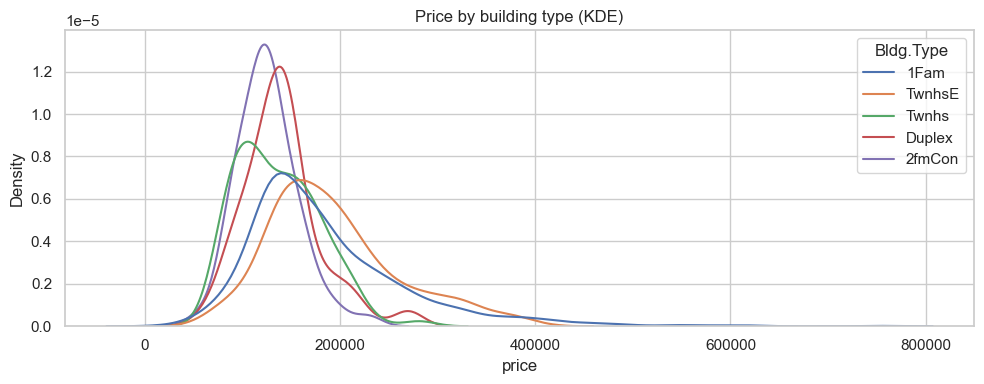

,count,mean,std,min,25%,50%,75%,max
Bldg.Type,,,,,,,,
1Fam,2425.0,184812.041237,82821.802329,12789.0,130000.0,165000.0,220000.0,755000.0
2fmCon,62.0,125581.709677,31089.239840,55000.0,106562.5,122250.0,140000.0,228950.0
Duplex,109.0,139808.935780,39498.973534,61500.0,118858.0,136905.0,153337.0,269500.0
Twnhs,101.0,135934.059406,41938.931130,73000.0,100500.0,130000.0,170000.0,280750.0
TwnhsE,233.0,192311.914163,66191.738021,71000.0,145000.0,180000.0,222000.0,392500.0


In [34]:
plt.figure(figsize=(10,4))

sns.kdeplot(data=ames, x="price", hue="Bldg.Type", fill=False, common_norm=False)
plt.title("Price by building type (KDE)")
plt.tight_layout()
plt.show()

ames.groupby("Bldg.Type")["price"].describe()

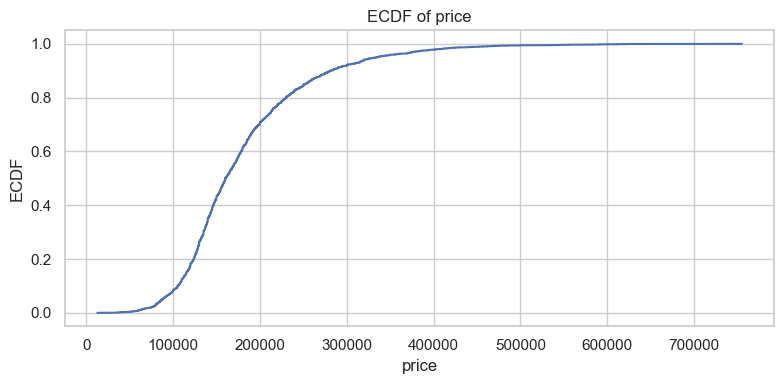

(np.int64(12789),
 np.float64(129500.0),
 np.float64(160000.0),
 np.float64(213500.0),
 np.int64(755000))

In [35]:
x = np.sort(ames["price"].dropna().to_numpy())
y = np.arange(1, len(x) + 1) / len(x)

plt.figure(figsize=(8,4))
plt.step(x, y, where="post")
plt.title("ECDF of price")
plt.xlabel("price")
plt.ylabel("ECDF")
plt.tight_layout()
plt.show()

np.min(x), np.quantile(x, 0.25), np.median(x), np.quantile(x, 0.75), np.max(x)

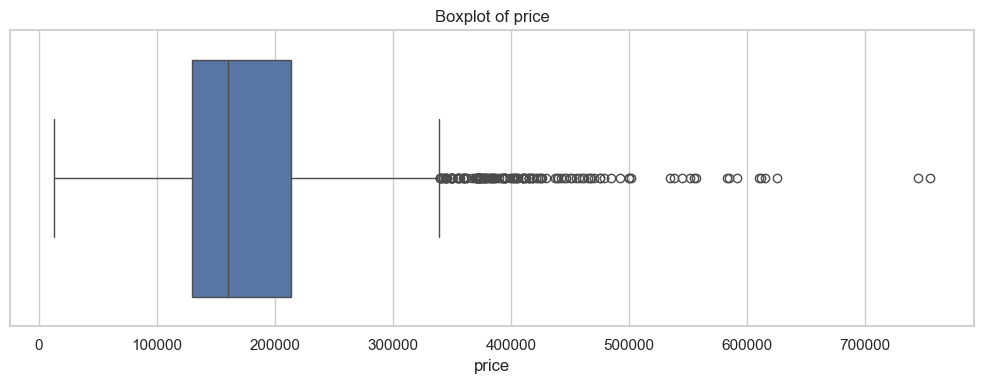

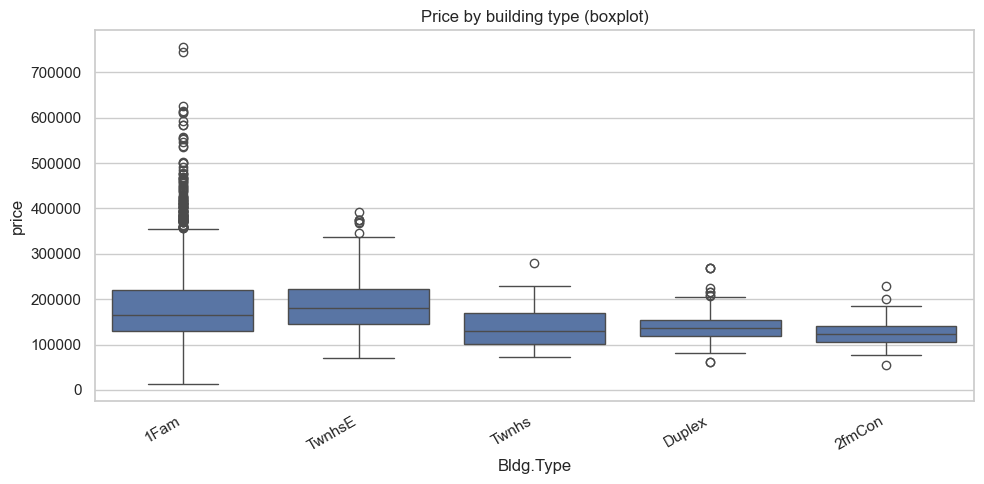

In [36]:
plt.figure(figsize=(10,4))

sns.boxplot(data=ames, x="price")
plt.title("Boxplot of price")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))
sns.boxplot(data=ames, x="Bldg.Type", y="price")
plt.title("Price by building type (boxplot)")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

In [37]:
q1 = ames["price"].quantile(0.25)
q3 = ames["price"].quantile(0.75)
iqr = q3 - q1

lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr

ames["price_outlier"] = (ames["price"] < lower) | (ames["price"] > upper)
ames["price_outlier"].value_counts(dropna=False), (lower, upper)

(price_outlier
 False    2793
 True      137
 Name: count, dtype: int64,
 (np.float64(3500.0), np.float64(339500.0)))

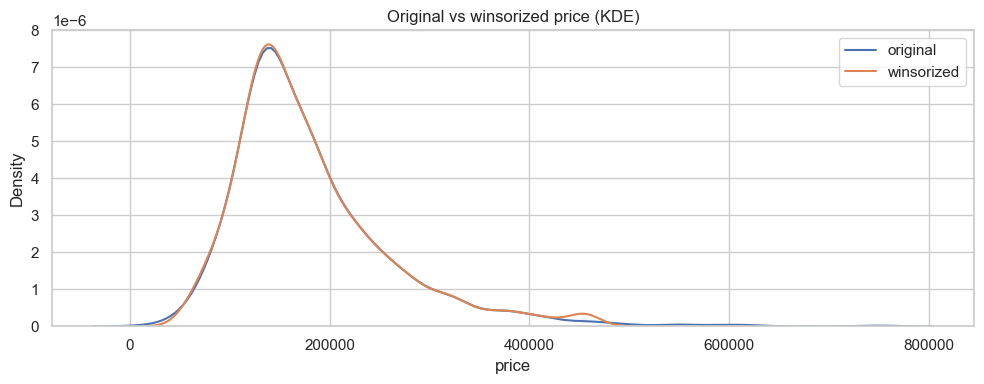

,price,price_winsor
count,2930.000000,2930.000000
mean,180796.060068,180091.154334
std,79886.692357,75842.579174
min,12789.000000,61756.070000
25%,129500.000000,129500.000000
50%,160000.000000,160000.000000
75%,213500.000000,213500.000000
max,755000.000000,456666.370000


In [38]:
# Winsorize at 1% and 99%
lo, hi = ames["price"].quantile([0.01, 0.99])
ames["price_winsor"] = ames["price"].clip(lower=lo, upper=hi)

plt.figure(figsize=(10,4))
sns.kdeplot(data=ames, x="price", fill=False, label="original")
sns.kdeplot(data=ames, x="price_winsor", fill=False, label="winsorized")
plt.title("Original vs winsorized price (KDE)")
plt.legend()
plt.tight_layout()
plt.show()

ames[["price", "price_winsor"]].describe()